In [1]:
import csv
import copy
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

source = "en"   
target = ["id", "ms", "fr", "ca", "es",  "pt",  "nl", "ru", "zh",  "de", "da", "el", "fi", "ko", "lt", "mk", "no", "pl", "ro", "sv", "uk", "it"]
languages = [ "zh","ko", "id", "ms",  "en", "nl", "de", "da",  "no", "sv", "fi", "lt",  "pl", "ru", "uk", "mk", "el",  "ro",  "it", "fr", "ca",  "es", "pt",  ]
keyword_languages = ["id", "ms", "fr", "es",  "pt",  "nl", "en", "ru", "zh"]

language_names = {"en": "English", "ms": "Malay", "pt":"Portuguese", "fr": "French", "id": "Indonesian", 
                  "nl": "Dutch", "es": "Spanish","zh":"Chinese", "ru": "Russian", "ca": "Catalan", "de": "German", "da": "Danish", 
                  "el": "Greek", "fi": "Finnish", "it": "Italian", "ko": "Korean", "lt": "Lithuanian", "mk": "Macedonian", "no": "Norwegian", 
                  "pl": "Polish", "ro": "Romanian", "sv": "Swedish", "uk": "Ukrainian"}

In [2]:
from src.util import load_strong_translations, load_worldlex_data, expand_chinese_characters
from src.word_mapping import calculate_frequency, get_wordlist

# worldlex frequency
# CHANGE freq_dir TO THE DIRECTORY OF WORLDLEX FREQUENCY FOLDER
freq = load_worldlex_data(freq_dir="word-freq", relative_frequency=False, average=False, 
                          source=["blog", "twitter"], languages=languages)

# conversion to simplified chinese from https://github.com/BYVoid/OpenCC
freq["zh"] = expand_chinese_characters(freq["zh"], convert="key", count_values=True)


#### Mapping words to English lemma

In [3]:
# 1. UNZIP lemma-strong-translations.zip. 2. CHANGE folder_path TO lemma-strong-translations-0.2
lemma_strong_translations = load_strong_translations(languages, folder_path="lemma-strong-translations-0.2", source="en_lemma")

# aggregate frequency based on lemmatized strong translations
tr_freq = calculate_frequency(freq, lemma_strong_translations, languages, source="en_lemma")
# final list of words (where words appear in > 1 languages)
wordlist = get_wordlist(tr_freq, languages) 

In [4]:
from src.statistics import final_score, rank_keyword_score, get_alphas, get_n, proportion_score, frequency_score,\
rank_keyword_by_freq_score

# proposed method of bayesian likelihood with Dirichlet prior, then ranked by language
smoothing_param = 1
n = get_n(freq)
alpha_w, alpha = get_alphas(tr_freq, smoothing_param)
bayesian_score = final_score(wordlist, languages, tr_freq, alpha, alpha_w, n, 
                             smoothing_param=smoothing_param, stddev=True, log=True)
# rank by s_w, word with S_w and argmax s_w
bayesian_rank, bayesian_rank_keyword_score = rank_keyword_score(wordlist, languages, bayesian_score) 

# baseline method measures difference in proportions
prop_score = proportion_score(wordlist, languages, tr_freq, n)
prop_rank, prop_rank_keyword_score = rank_keyword_score(wordlist, languages, prop_score)

# baseline method measures difference in raw frequency, rank by ascending and descending 
freq_score = frequency_score(wordlist, languages, tr_freq, n)
asc_rank, asc_rank_keyword_score = rank_keyword_by_freq_score(wordlist, languages, freq_score, descending=False)
des_rank, des_rank_keyword_score = rank_keyword_by_freq_score(wordlist, languages, freq_score, descending=True)

clf_ranks = {"bayesian": bayesian_rank, "proportion": prop_rank, "ascending": asc_rank, "descending": des_rank}

In [5]:
from src.evaluation import sort_rank_by_score

bayes_sc, bayes_sorted_sc, bayes_word_sc_rank = sort_rank_by_score(bayesian_rank_keyword_score)
prop_sc, prop_sorted_sc, prop_word_sc_rank = sort_rank_by_score(prop_rank_keyword_score)
asc_sc, asc_sorted_sc, asc_word_sc_rank = sort_rank_by_score(asc_rank_keyword_score, reverse=False)
des_sc, des_sorted_sc, des_word_sc_rank = sort_rank_by_score(des_rank_keyword_score)

# {w: S_w}
sc = {"bayesian": bayes_sc, "proportion": prop_sc, "ascending": asc_sc, "descending": des_sc}
# [words sorted by S_w]
sorted_sc = {"bayesian": bayes_sorted_sc, "proportion": prop_sorted_sc, 
             "ascending": asc_sorted_sc, "descending": des_sorted_sc}
# {w: ranking by S_w, words of same ranks have same S_w}
word_sc_rank = {"bayesian": bayes_word_sc_rank, "proportion": prop_word_sc_rank, 
             "ascending": asc_word_sc_rank, "descending": des_word_sc_rank}

In [11]:
from src.keywords import  load_and_translate_keywords
# load all keywords

cultural_keywords, concept_words_language, expected_keywords, all_keywords_en, available_keywords,\
internal_keywords, external_keywords = load_and_translate_keywords(lemma_strong_translations, keyword_languages, "en_lemma", wordlist)

In [12]:
from src.statistics import random_baseline, always_english_baseline, majority_baseline_non_english
# other baselines

# rank languages in random
random_rank = random_baseline(wordlist, tr_freq, languages) 
# rank english as 1 if the word exists in english corpus, rank randomly otherwise
always_en_rank = always_english_baseline(wordlist, tr_freq, languages) 
# rank the majority non-english language as 1 if word exists in the language, otherwise, rank randomly
majority_non_en_rank = majority_baseline_non_english(wordlist, tr_freq, languages, available_keywords)

clf_ranks["random"] = random_rank
clf_ranks["always_en"] = always_en_rank
clf_ranks["majority_non_en"] = majority_non_en_rank

#### Language classification of gold key words

In [13]:
from collections import Counter
def get_best_possible_mean_rank(lang_keywords):
    all_kws = [kw for kws in lang_keywords.values() for kw in kws]
    return np.mean([i+1 for kw, count in Counter(all_kws).items() for i in range(count)])

print(f"Best possible mean rank of unrevealing keywords: {get_best_possible_mean_rank(internal_keywords)}")
print(f"Best possible mean rank of revealing keywords: {get_best_possible_mean_rank(external_keywords)}")
print(f"Best possible mean rank of all keywords: {get_best_possible_mean_rank(available_keywords)}")

Best possible mean rank of unrevealing keywords: 1.1324200913242009
Best possible mean rank of revealing keywords: 1.1651917404129795
Best possible mean rank of all keywords: 1.1523297491039426


In [14]:
from src.evaluation import evaluate_keyword_classifications
# internal = revealing keywords; external = unrevealing keywords, descending = frequency  
evaluate_keyword_classifications(clf_ranks, external_keywords, internal_keywords, available_keywords)


method         : recall, mean rank (ext/int/overall)
bayesian       : (0.43/0.20/0.34), (4.48/5.52/4.89)
proportion     : (0.37/0.20/0.30), (4.35/5.42/4.77)
ascending      : (0.02/0.00/0.01), (16.01/13.69/15.10)
descending     : (0.37/0.20/0.30), (4.35/5.42/4.77)
random         : (0.07/0.07/0.07), (10.08/10.25/10.15)
always_en      : (0.35/0.57/0.43), (7.92/5.01/6.78)
majority_non_en: (0.15/0.12/0.14), (9.48/9.22/9.38)


In [15]:
from src.evaluation import evaluate_by_keyword_categories_language

evaluation_by_lang = evaluate_by_keyword_categories_language(external_keywords, internal_keywords, available_keywords,
                                            language_names, clf_ranks["bayesian"], verbose=True, decimal_place=2)

Recall of rank 1 keywords across languages: 
language, external, internal, overall
en: 0.39, 0.22, 0.3
es: 0.5, 0.22, 0.41
fr: 0.53, 0.0, 0.49
id: 0.35, 1.0, 0.39
nl: 0.25, 1.0, 0.29
pt: 0.52, 0.27, 0.42
ms: 0.4, 0.04, 0.14
zh: 0.34, 0.25, 0.32
ru: 0.52, 0.09, 0.39

(mean, std) of keyword ranks across languages: 
language, external, internal, overall
en: (3.57,3.89), (6.32,5.65), (4.99,5.06)
es: (3.3,4.16), (3.83,2.64), (3.47,3.74)
fr: (3.29,3.59), (7.75,4.99), (3.62,3.84)
id: (10.12,8.66), (1.0,n/a), (9.61,8.67)
nl: (6.38,5.63), (1.0,n/a), (6.06,5.61)
pt: (3.81,4.97), (4.67,4.53), (4.17,4.74)
ms: (2.5,2.42), (3.63,2.6), (3.32,2.57)
zh: (8.84,8.38), (5.75,6.48), (8.0,7.96)
ru: (4.15,5.04), (5.45,4.18), (4.53,4.79)


#### Word ranking by cultural/statistical distincitiveness

In [16]:
from src.evaluation import get_recall_by_range_sum
# this might take a couple of minutes to run

keyword_id_recall_1 = get_recall_by_range_sum(external_keywords, internal_keywords, word_sc_rank, clf_ranks, 1)

<AxesHostAxes:title={'center':'Top 10% ranks'}>

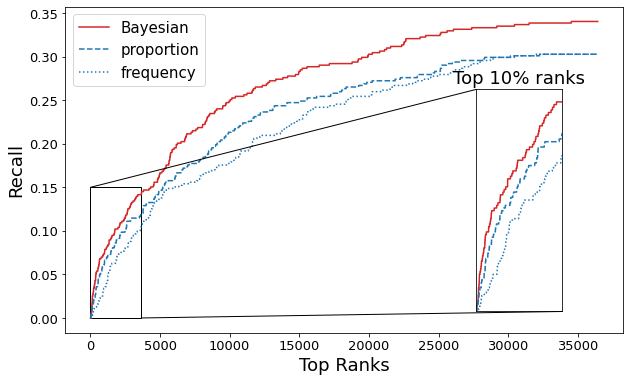

In [18]:
from src.visualisation import compare_recall_ranks_all_methods_inset
import warnings
warnings.filterwarnings('ignore')

top_10_percent = len(wordlist) * 0.1
compare_recall_ranks_all_methods_inset(keyword_id_recall_1, method_style_dict={"bayesian": "r-", "proportion":"k--", "descending": "k:"},
                                       method_label_dict={"bayesian": "Bayesian", "proportion":"proportion", "descending": "frequency"},
                                       method_colour_dict={"bayesian": "tab:red", "proportion":"tab:blue", "ascending": "tab:blue", "descending": "tab:blue"},
                                       top_n=len(wordlist), inset_range=[0, top_10_percent, 0.00, 0.15], percent=10)
# plt.savefig("figures/recall_ranks_inset.pdf")

#### Error analysis (lowly ranked keywords)
1. Keywords classified lowly across languages

In [19]:
for lang, keywords in internal_keywords.items():
    print(f"{lang}: {[kw  for kw in keywords if clf_ranks['bayesian'][lang][kw] >= 10 ]}")

id: []
ms: ['honor', 'respect']
fr: ['pray', 'soul']
es: ['honestly']
pt: ['suburb']
nl: []
en: ['empirical', 'behaviour', 'language', 'autonomy', 'truth', 'rational', 'information', 'soul', 'happiness', 'economy', 'country', 'emotion', 'culture', 'dialogue', 'understand', 'tolerant', 'efficiency', 'justice', 'private', 'undoubtedly', 'request', 'impartial', 'commitment', 'tolerance', 'opinion', 'deadline', 'reality', 'apparently', 'personal', 'freedom', 'spirit', 'communication']
ru: ['long', 'truth']
zh: ['cool', 'heart']


#### Language pair similarities

In [14]:
from src.evaluation import pearson_correlation
def correlation_by_language_pairs(languages, word_ranks):
    corr = {lang: {} for lang in languages}
    for i, lang1 in enumerate(languages):
        for lang2 in languages[i:]:
            pearsc = pearson_correlation(word_ranks[lang1], word_ranks[lang2], label=None, verbose=False, outer=False)
            corr[lang1][lang2] = pearsc
            corr[lang2][lang1] = pearsc
    return corr

rank_correlation_by_language = correlation_by_language_pairs(languages, clf_ranks["bayesian"])

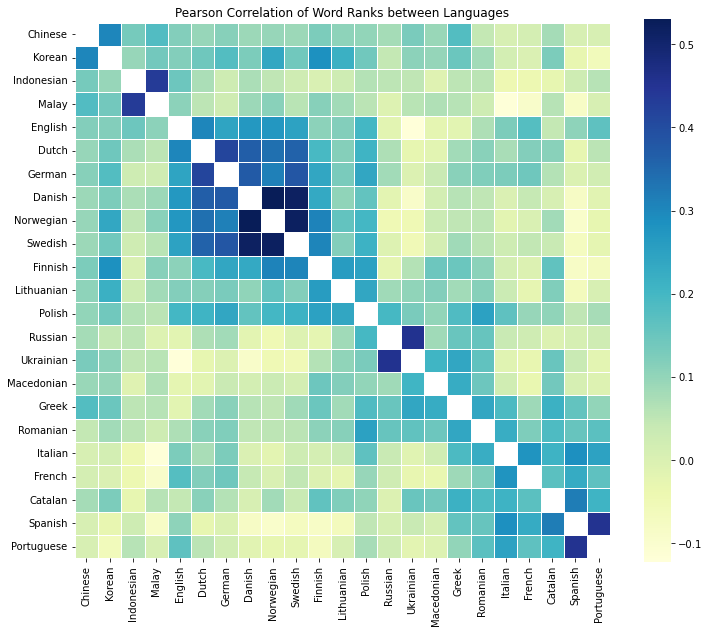

In [15]:
import matplotlib.patches as mpatches
import seaborn as sns
lang_ticks = [language_names[lang] for lang in languages]
fig, ax = plt.subplots(1, 1, sharey=False)

fig.set_figheight(10)
fig.set_figwidth(12)

value_mtx = np.array([[rank_correlation_by_language[lang][lang2] for lang2 in languages] for lang in languages])
mask_mtx = np.array([[True if lang==lang2 else False for lang2 in languages] for lang in languages])
ax = sns.heatmap(value_mtx, linewidths=.5, xticklabels=lang_ticks, yticklabels=lang_ticks, square=True, ax=ax, fmt='g', cmap="YlGnBu", mask=mask_mtx)
# plt.savefig("figures/pairwise_sim_lang.pdf",bbox_inches='tight')
plt.title("Pearson Correlation of Word Ranks between Languages")
plt.show()


#### Samples of word mapping by lemmatization
Bold are words salient in terms of frequency, underlined are gold keywords.

In [16]:
from src.util import load_lemmatized, load_lemma2lemma_translations
from src.visualisation import tabulate_keyword_ranks

word_lemma = {lang: load_lemmatized("lemmatized/{}.txt".format(lang)) for lang in languages if lang != "zh"}
lemma_lemma_translations = load_lemma2lemma_translations(languages, word_lemma, lemma_strong_translations)

language_names["en_lemma"] = "English"
tabulate_keyword_ranks(wordlist, bayesian_score, sc["bayesian"], sorted_sc["bayesian"], 
                       word_sc_rank["bayesian"], lemma_lemma_translations,
                       available_keywords, language_names, "en_lemma", target, keyword_languages)

Ranked keywords by class score with facebook mapping
rank, class score, Indonesian, Malay, French, Catalan, Spanish, Portuguese, Dutch, Russian, Chinese, German, Danish, Greek, Finnish, Korean, Lithuanian, Macedonian, Norwegian, Polish, Romanian, Swedish, Ukrainian, Italian, English, 
1 2274.86 N/A, N/A, moi, N/A, eu, mij, i, меня, 我, 
2 1744.49 one/ones/satu, ones/satu, N/A, uno, N/A, eén/één, one, один/одно/одна, 一/一个, 
3 1571.87 dalam/ins, dalam, in/dans, ins, ins, ins, in, N/A, N/A, 
4 1538.65 N/A, N/A, lui, N/A, N/A, het, it, это, 它, 
5 1331.1 were/adalah, were/adalah/jadi/been/ialah, être, estar/ser, estar/ser, zijn, be, быть/была/являться/были/был, N/A, 
6 1290.47 N/A, N/A, N/A, quien/quién, quem, wie, who, кто, 谁, 
7 1242.68 ada, ada, N/A, N/A, N/A, N/A, there, там, N/A, 
8 1238.91 akan/sedia, rela/akan, être, dispuesto, N/A, zullen, will, будет, 将, 
9 1189.26 dos/laku, dos/done, dos, hacer, fazer, dos/doen, do, сделать, N/A, 
10 1115.23 man/mans, mans, man/mans/homme, man/mans

#### Independence Tests

In [17]:
import random, math
random.seed(2022)
import copy
import warnings
from src.evaluation import recall_mean_std_by_keyword_categories, evaluate_by_vocab

recall_k=1
nsamples = 100
wordlist_clf_eval, wordlist_rank_eval = evaluate_by_vocab(wordlist, tr_freq, lemma_strong_translations, n=n, smoothing_param=smoothing_param, 
                                                          recall_k=recall_k, npartitions=nsamples, keyword_languages=keyword_languages)


In [18]:
from src.evaluation import pvalue_by_wordlist, sample_mean_stddev
rank_eval_idx=500
metric_names={"clf-all-mean": "mean keyword classification", "clf-all-recall": "correct keyword classification", "rank-all-recall":f"recall@{rank_eval_idx*recall_k}"}

method_pairs = [("bayesian", "proportion"), ("bayesian", "descending"), ("proportion", "descending")]
clf_rank_pair_pvalue = pvalue_by_wordlist(method_pairs, wordlist_clf_eval, wordlist_rank_eval, metrics=["rank"], rank_eval_idx=rank_eval_idx)

random_method_pairs = ("bayesian", "random"), ("proportion", "random"), ("descending", "random")
clf_rank_pair_pvalue_random = pvalue_by_wordlist(random_method_pairs, wordlist_clf_eval, wordlist_rank_eval, metrics=["clf"], rank_eval_idx=rank_eval_idx)

mean_stddev = {}
for met in ["bayesian", "proportion", "descending", "random"]:
    if met == "random":
        mean_stddev[met] = sample_mean_stddev(met, wordlist_clf_eval, wordlist_rank_eval, metrics=["clf"], rank_eval_idx=rank_eval_idx) 
    else:
        mean_stddev[met] = sample_mean_stddev(met, wordlist_clf_eval, wordlist_rank_eval, metrics=["clf", "rank"], rank_eval_idx=rank_eval_idx) 
            

Mean and standard deviation of samples 

In [19]:
longest = max([len(name) for name in metric_names.values()])
for met, m_std in mean_stddev.items():
    print(f"###### {met.upper()} ######")
    for metric, mean in m_std["mean"].items():
        print(f"{metric_names.get(metric, metric)}{' '*(longest-len(metric_names.get(metric, metric)))}: mean={mean}, std={m_std['stddev'][metric]}")
    print()

###### BAYESIAN ######
mean keyword classification   : mean=4.894826492693437, std=0.2416267556362558
correct keyword classification: mean=0.3406473450447623, std=0.025197623527198565
recall@500                    : mean=0.054720175620174685, std=0.009565922603054467

###### PROPORTION ######
mean keyword classification   : mean=4.781832360869813, std=0.21805786704841268
correct keyword classification: mean=0.30411162416879955, std=0.02468031316001174
recall@500                    : mean=0.038685994739697624, std=0.0072839858313249045

###### DESCENDING ######
mean keyword classification   : mean=4.781832360869813, std=0.21805786704841268
correct keyword classification: mean=0.30411162416879955, std=0.02468031316001174
recall@500                    : mean=0.015594979295065599, std=0.0049993232903363235

###### RANDOM ######
mean keyword classification   : mean=9.909781382575392, std=0.24229068064866918
correct keyword classification: mean=0.06435959323470059, std=0.008922125998727224



Comparison over repeated values (pvalue = proportion of method1 values < method2 values)

In [20]:

print(f"p-value over {nsamples} repeated samples for comparison in classification \n")
for clf_pair, result in clf_rank_pair_pvalue_random.items():
    print(f"##### {clf_pair.split('-')[0].upper()} vs. {clf_pair.split('-')[1].upper()} #####")
    for metric, res in result.items():
        try:
            print(f"{metric_names.get(metric, metric)}{' '*(longest-len(metric_names.get(metric, metric)))}: {res.statistic}, pval={res.pvalue}")
        except:
            print(f"{metric_names.get(metric, metric)}{' '*(longest-len(metric_names.get(metric, metric)))}: {res}")
    print()

print(f"p-value over {nsamples} repeated samples for comparison in ranks \n")
for clf_pair, result in clf_rank_pair_pvalue.items():
    print(f"##### {clf_pair.split('-')[0].upper()} vs. {clf_pair.split('-')[1].upper()} #####")
    for metric, res in result.items():
        try:
            print(f"{metric_names.get(metric, metric)}{' '*(longest-len(metric_names.get(metric, metric)))}: {res.statistic}, pval={res.pvalue}")
        except:
            print(f"{metric_names.get(metric, metric)}{' '*(longest-len(metric_names.get(metric, metric)))}: {res}")
    print()


p-value over 100 repeated samples for comparison in classification 

##### BAYESIAN vs. RANDOM #####
mean keyword classification   : 1.0
correct keyword classification: 0.0

##### PROPORTION vs. RANDOM #####
mean keyword classification   : 1.0
correct keyword classification: 0.0

##### DESCENDING vs. RANDOM #####
mean keyword classification   : 1.0
correct keyword classification: 0.0

p-value over 100 repeated samples for comparison in ranks 

##### BAYESIAN vs. PROPORTION #####
recall@500                    : 0.0

##### BAYESIAN vs. DESCENDING #####
recall@500                    : 0.0

##### PROPORTION vs. DESCENDING #####
recall@500                    : 0.0



#### Standard Error

In [21]:
wordlist_rank_eval_steps = {method: np.array([reval[method]["all"]["sum"] for reval in wordlist_rank_eval]).T 
                            for method in wordlist_rank_eval[0].keys()}   # (steps, samples)
# rank mean and standard error per step
rank_mean_estimate = {method: np.mean(wordlist_rank_eval_steps[method], axis=1) for method in wordlist_rank_eval[0].keys()}
rank_stde_estimate = {method: np.std(wordlist_rank_eval_steps[method], axis=1)/np.sqrt(nsamples) for method in wordlist_rank_eval[0].keys()}

error_estimate = {method: (rank_mean_estimate[method]-rank_stde_estimate[method], rank_mean_estimate[method]+rank_stde_estimate[method]) 
                  for method in wordlist_rank_eval[0].keys()}

In [24]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

def compare_recall_ranks_all_methods_inset(method_cat_bin_ratio_dict, method_style_dict, method_label_dict,
                                           method_colour_dict, top_n=None, inset_range=[0, 5000, 0.01, 0.20],
                                           percent=10, fill_between=None, inset_out=False):
    fig, ax = plt.subplots(figsize=[10, 6])

    method0 = list(method_style_dict.keys())[0]
    top_n = len(method_cat_bin_ratio_dict[method0]["all"]["sum"]) if top_n is None else top_n

    bins = (np.array(list(range(0, len(method_cat_bin_ratio_dict[method0]["all"]["sum"]), 1))) + 1)

    for method, sty in method_style_dict.items():
        plt.plot(bins, method_cat_bin_ratio_dict[method]["all"]["sum"], sty, label=method_label_dict[method],
                 color=method_colour_dict[method])
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel('Recall', fontsize=18)
    plt.xlabel('Top Ranks', fontsize=18)
    # plt.title('Recall @ Ranks for Correctly Identified Keywords',fontweight="bold", size=18)
    plt.legend(loc="best", prop={'size': 15})

    if fill_between is not None:
        for method in method_style_dict:
            plt.fill_between(bins, fill_between[method][0], fill_between[method][1], color=method_colour_dict[method],
                             alpha=0.4)

    if inset_range is not None:
        bbox_to_anchor = (0.4, 0.05, 0.85, .1) if inset_out else (0.4, 0.05, .5, .3)
        axins = zoomed_inset_axes(ax, 1.7, loc=4, bbox_to_anchor=bbox_to_anchor,
                                  bbox_transform=ax.transAxes)

        for method, sty in method_style_dict.items():
            axins.plot(bins[:top_n], method_cat_bin_ratio_dict[method]["all"]["sum"][:top_n], sty,
                       label=method_label_dict[method], color=method_colour_dict[method])

        if fill_between is not None:
            for method in method_style_dict:
                axins.fill_between(bins[:top_n], fill_between[method][0][:top_n], fill_between[method][1][:top_n],
                                   color=method_colour_dict[method],
                                   alpha=0.3)

        axins.axis(inset_range)
        axins.set_yticks([])
        axins.set_xticks([])
        axins.set_title('Top {}% ranks'.format(percent), fontsize=18)
        plt.yticks(visible=False)
        plt.xticks(visible=False)

        mark_inset(ax, axins, loc1=4, loc2=2, fc="none", ec="0.0")
    return axins

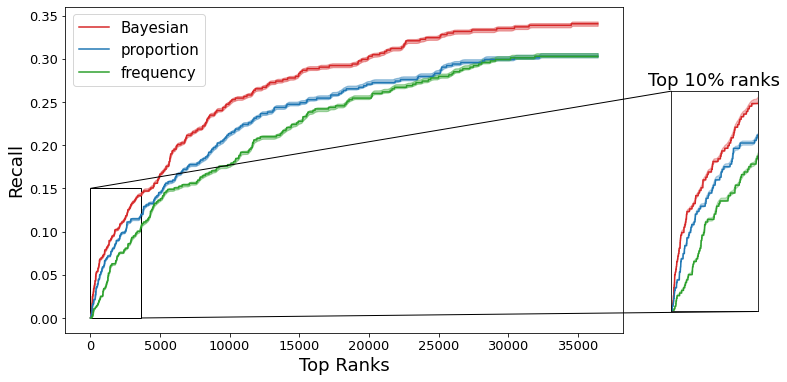

In [25]:
zoomed_axins = compare_recall_ranks_all_methods_inset(keyword_id_recall_1, method_style_dict={"bayesian": "r-", "proportion":"k-", "descending": "k-"},
                                       method_label_dict={"bayesian": "Bayesian", "proportion":"proportion", "descending": "frequency"},
                                       method_colour_dict={"bayesian": "tab:red", "proportion":"tab:blue", "descending": "tab:green"},
                                       top_n=len(wordlist), inset_range=[0, top_10_percent, 0.00, 0.15], percent=10,
                                       fill_between=error_estimate, inset_out=True)
plt.savefig("figures/recall_ranks_inset_stderror.pdf", format="pdf", bbox_extra_artists=(zoomed_axins,), bbox_inches='tight')

\textbf{Chinese}\\灵魂, 
\textbf{Korean}\\영혼\\소울, 
\textbf{Indonesian}\\soul, 
\textbf{Malay}\\jiwa, 
\textbf{English}\\soul, 
\textbf{Dutch}\\ziel\\soul, 
\textbf{German}\\seele\\soul, 
\textbf{Danish}\\sjæl\\sjæle\\soul, 
\textbf{Norwegian}\\sjel\\sjeler\\sjelene\\soul, 
\textbf{Swedish}\\själ\\själar, 
\textbf{Finnish}\\sielun\\sielut\\sieluja\\sielu, 
\textbf{Lithuanian}\\sielos\\siela\\sielas, 
\textbf{Polish}\\duszy\\dusza\\duszę\\dusze\\dusz\\soul, 
\textbf{Russian}\\душа, 
\textbf{Ukrainian}\\душі\\душа, 
\textbf{Macedonian}\\душа\\души, 
\textbf{Greek}\\ψυχή\\ψυχές, 
\textbf{Romanian}\\sufletul\\suflet\\sufletele\\suflete\\soul, 
\textbf{Italian}\\anima\\soul, 
\textbf{French}\\âme\\soul, 
\textbf{Catalan}\\ànima\\soul, 
\textbf{Spanish}\\alma\\soul, 
\textbf{Portuguese}\\alma\\almas\\soul
zh,ko,id,ms,en,nl,de,da,no,sv,fi,lt,pl,ru,uk,mk,el,ro,it,fr,ca,es,pt
(zh, 4.0192056281452844e-05)
(ko, 1.0642502781387774e-05)
(id, 4.445906306970487e-06)
(ms, 0.00028936555252148167)
(en, 0.0

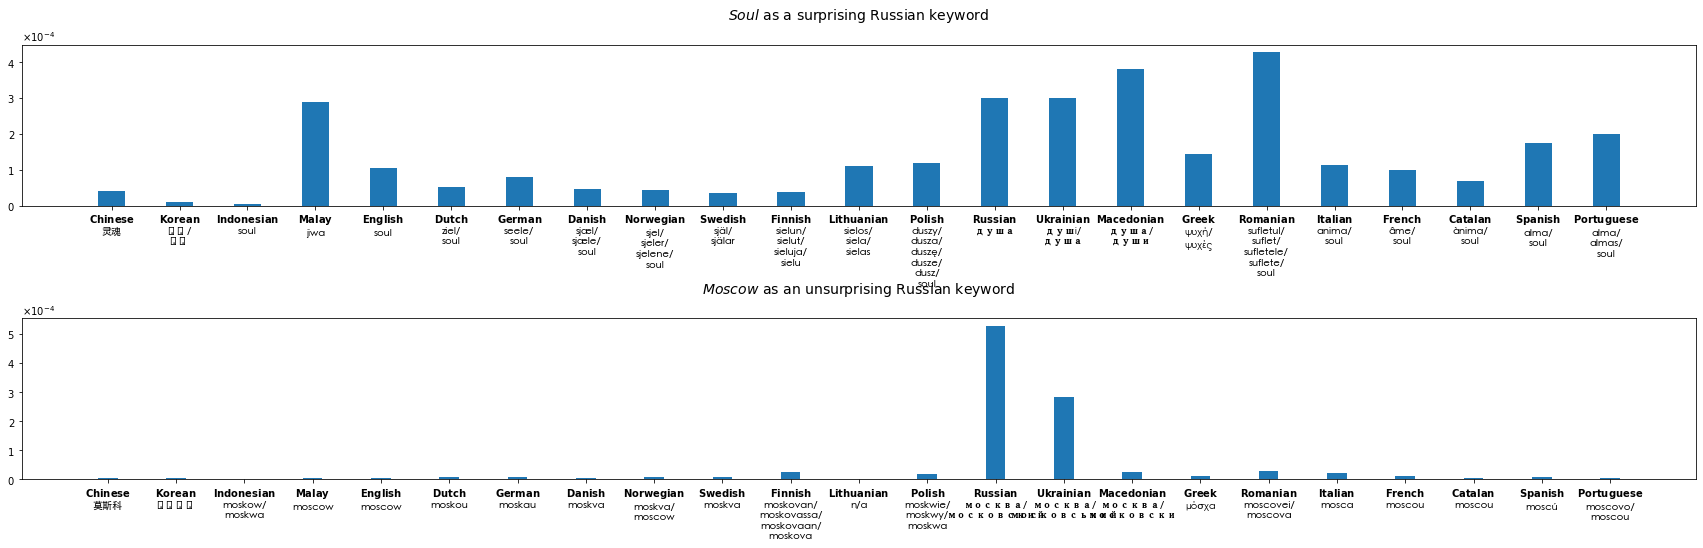

In [40]:
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots(2, figsize=[30,8], sharey=False)

ax[0].ticklabel_format(style="sci", axis='y', scilimits=(0,1),useMathText=True)

word = "soul"
sep = 5
ax[0].bar(np.array(range(len(languages))) * sep, [tr_freq[lang][word]/n[lang] if word in tr_freq[lang] else 0 for lang in languages], width=2) 
ax[0].set_xticks(np.array(range(len(languages))) * sep)
islam_labels = {}
for lang in languages:
    if word in lemma_strong_translations[r"en_lemma-{}".format(lang)]:
        if lang!="zh":
            islam_labels[lang] = get_lemma_set(lang, word)
        else:
            islam_labels[lang] = lemma_strong_translations["en_lemma-{}".format(lang)][word]
    else:
         islam_labels[lang] = ["n/a"]
            
ax[0].set_xticklabels([r"$\bf{}$".format(language_names[lang]) + "\n"+"/\n".join(islam_labels[lang]).lower()
                    for lang in languages],
                  fontname="Heiti TC")
ax[0].set_title("$Soul$ as a surprising Russian keyword", fontsize=14, pad=25, fontname="sans-serif")
# ax[0].set_ylabel("normalized frequency")

fig.subplots_adjust(hspace=0.7)
# fig.set_figheight(3)
# fig.set_figwidth(10)


print(", \n".join([r"\textbf{{{}}}\\{}".format(language_names[lang], "\\\\".join(islam_labels[lang])) for lang in languages])) 
print(",".join(languages))
print("\n".join(["({}, {})".format(l, stat) for l, stat in zip(languages, [tr_freq[lang][word]/n[lang] if word in tr_freq[lang] else 0 for lang in languages])]))

word = "moscow"
sep=7
ax[1].bar(np.array(range(len(languages))) * sep, [tr_freq[lang][word]/n[lang] if word in tr_freq[lang] else 0 for lang in languages], width=2) 
ax[1].set_xticks(np.array(range(len(languages))) * sep)
pat_labels = {}

for lang in languages:
    if word in lemma_strong_translations[r"en_lemma-{}".format(lang)]:
        if lang!="zh":
            pat_labels[lang] = get_lemma_set(lang, word)
        else:
            pat_labels[lang] = lemma_strong_translations["en_lemma-{}".format(lang)][word]
    else:
         pat_labels[lang] = ["n/a"]

print(pat_labels)            
ax[1].set_xticklabels([r"$\bf{}$".format(language_names[lang]) + "\n"+"/\n".join(pat_labels[lang]).lower() for lang in languages],
                  fontname="Heiti TC")
ax[1].set_title("$Moscow$ as an unsurprising Russian keyword", fontsize=14, pad=25, fontname="sans-serif")
ax[1].ticklabel_format(style="sci", axis='y', scilimits=(0,1), useMathText=True)


print(", \n".join(["\\textbf{{{}}}\\\{}".format(language_names[lang], "\\\\".join(pat_labels[lang]).lower()) for lang in languages])) 
print("\n".join(["({}, {})".format(l, stat) for l, stat in zip(languages, [tr_freq[lang][word]/n[lang] if word in tr_freq[lang] else 0 for lang in languages])]))

plt.savefig("figures/dusha_moscow.pdf")

\textbf{Chinese}\\心\\心脏, 
\textbf{Korean}\\심장\\하트, 
\textbf{Indonesian}\\jantung\\hati\\heart\\hearts, 
\textbf{Malay}\\jantung\\hati\\heart\\hearts, 
\textbf{English}\\heart, 
\textbf{Dutch}\\hartje\\hart\\hearts, 
\textbf{German}\\herzens\\herz\\herzen\\heart\\hearts, 
\textbf{Danish}\\hjerte\\hjertet\\hjerter\\heart, 
\textbf{Norwegian}\\hjertet\\hjerte\\heart\\hearts, 
\textbf{Swedish}\\hjärta\\hjärtat\\hjärtan, 
\textbf{Finnish}\\sydän\\sydämen\\sydäntä\\sydämiä\\sydämet, 
\textbf{Lithuanian}\\širdies\\širdis\\širdy\\širdys, 
\textbf{Polish}\\serca\\serce\\serc\\heart\\hearts, 
\textbf{Russian}\\сердце, 
\textbf{Ukrainian}\\серце, 
\textbf{Macedonian}\\срце\\срца, 
\textbf{Greek}\\καρδιά\\καρδια\\καρδία\\καρδιές, 
\textbf{Romanian}\\inima\\inimă\\inimile\\inimi, 
\textbf{Italian}\\cuori\\cuore\\heart\\hearts, 
\textbf{French}\\coeur\\cœur\\heart, 
\textbf{Catalan}\\cor\\heart, 
\textbf{Spanish}\\corazón\\corazon\\heart\\hearts, 
\textbf{Portuguese}\\coração\\heart\\hearts
zh,ko,id

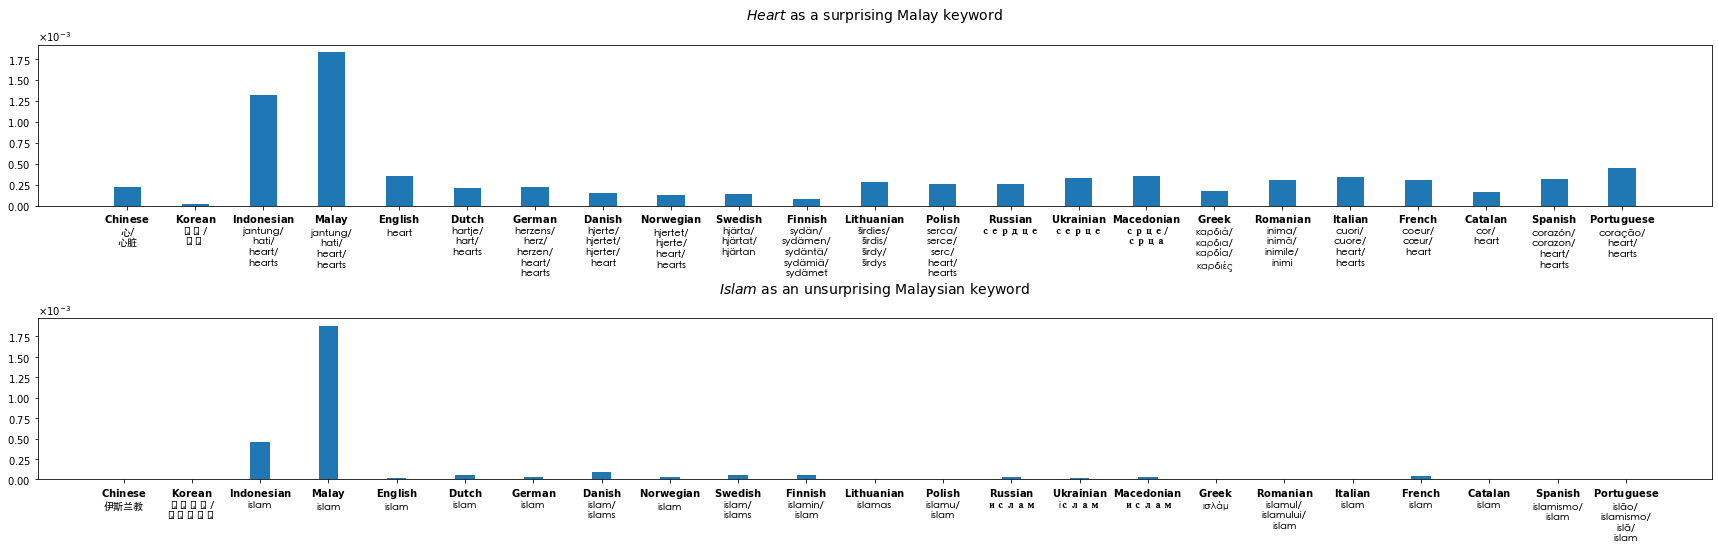

In [41]:
fig, ax = plt.subplots(2, figsize=[30,8], sharey=False)

ax[0].ticklabel_format(style="sci", axis='y', scilimits=(0,1),useMathText=True)

word = "heart"
sep = 5
ax[0].bar(np.array(range(len(languages))) * sep, [tr_freq[lang][word]/n[lang] if word in tr_freq[lang] else 0 for lang in languages], width=2) 
ax[0].set_xticks(np.array(range(len(languages))) * sep)
islam_labels = {}
for lang in languages:
    if word in lemma_strong_translations[r"en_lemma-{}".format(lang)]:
        if lang!="zh":
            islam_labels[lang] = get_lemma_set(lang, word)
        else:
            islam_labels[lang] = lemma_strong_translations["en_lemma-{}".format(lang)][word]
    else:
         islam_labels[lang] = ["n/a"]
            
ax[0].set_xticklabels([r"$\bf{}$".format(language_names[lang]) + "\n"+"/\n".join(islam_labels[lang]).lower()
                    for lang in languages],
                  fontname="Heiti TC")
ax[0].set_title("$Heart$ as a surprising Malay keyword", fontsize=14, pad=25, fontname="sans-serif")
# ax[0].set_ylabel("normalized frequency")

fig.subplots_adjust(hspace=0.7)
# fig.set_figheight(3)
# fig.set_figwidth(10)


print(", \n".join([r"\textbf{{{}}}\\{}".format(language_names[lang], "\\\\".join(islam_labels[lang])) for lang in languages])) 
print(",".join(languages))
print("\n".join(["({}, {})".format(l, stat) for l, stat in zip(languages, [tr_freq[lang][word]/n[lang] if word in tr_freq[lang] else 0 for lang in languages])]))

word = "islam"
sep=7
ax[1].bar(np.array(range(len(languages))) * sep, [tr_freq[lang][word]/n[lang] if word in tr_freq[lang] else 0 for lang in languages], width=2) 
ax[1].set_xticks(np.array(range(len(languages))) * sep)
pat_labels = {}

for lang in languages:
    if word in lemma_strong_translations[r"en_lemma-{}".format(lang)]:
        if lang!="zh":
            pat_labels[lang] = get_lemma_set(lang, word)
        else:
            pat_labels[lang] = lemma_strong_translations["en_lemma-{}".format(lang)][word]
    else:
         pat_labels[lang] = ["n/a"]

print(pat_labels)            
ax[1].set_xticklabels([r"$\bf{}$".format(language_names[lang]) + "\n"+"/\n".join(pat_labels[lang]).lower() for lang in languages],
                  fontname="Heiti TC")
ax[1].set_title("$Islam$ as an unsurprising Malaysian keyword", fontsize=14, pad=25, fontname="sans-serif")
ax[1].ticklabel_format(style="sci", axis='y', scilimits=(0,1), useMathText=True)


print(", \n".join(["\\textbf{{{}}}\\\{}".format(language_names[lang], "\\\\".join(pat_labels[lang]).lower()) for lang in languages])) 
print("\n".join(["({}, {})".format(l, stat) for l, stat in zip(languages, [tr_freq[lang][word]/n[lang] if word in tr_freq[lang] else 0 for lang in languages])]))

# plt.savefig("figures/dusha_moscow.pdf")

In [32]:
bayesian_scs = {}
bayesian_sorted_scs = {}
bayesian_scores = {}
bayesian_clf_ranks = {}
bayesian_word_sc_ranks = {}
smoothing_params = [ 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]
# smoothing_params += [7**2, 8**2, 9**2, 11**2, 7**3, 8**3, 9**3, 11**3]
for smoothing_param in smoothing_params:
    alpha_w, alpha = get_alphas(tr_freq, smoothing_param)
    n = get_n(freq)
    bayesian_score = final_score(wordlist, languages, tr_freq, alpha, alpha_w, n, 
                                 smoothing_param=smoothing_param, stddev=True, log=True)
    bayesian_rank, bayesian_rank_keyword_score = rank_keyword_score(
        wordlist, languages, bayesian_score)
    bayes_sc, bayes_sorted_sc, bayesian_word_sc_rank = sort_rank_by_score(bayesian_rank_keyword_score)
    bayesian_scs[str(smoothing_param)] = bayes_sc
    bayesian_scores[str(smoothing_param)] = bayesian_score
    bayesian_sorted_scs[str(smoothing_param)] = bayes_sorted_sc
    bayesian_clf_ranks[str(smoothing_param)] = bayesian_rank
    bayesian_word_sc_ranks[str(smoothing_param)] = bayesian_word_sc_rank

bayesian_keyword_id_recall_1 = get_recall_by_range_sum(
    external_keywords, internal_keywords, bayesian_word_sc_ranks, bayesian_clf_ranks, 1)


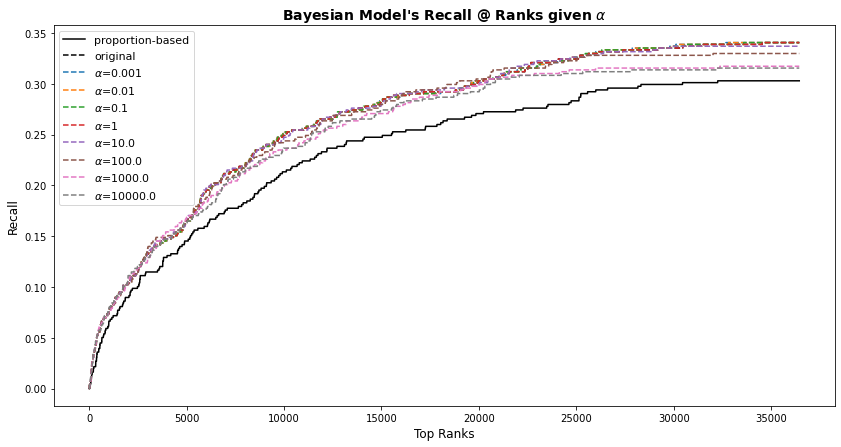

In [42]:
import matplotlib.ticker as mticker


smoothing_params = [ 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]
top_n = len(wordlist)

bins = (np.array(list(range(0, len(sorted_sc["bayesian"]), 1))) + 1)[:top_n]

width = 0.8

plt.figure(figsize=(14,7))

plt.plot(bins, keyword_id_recall_1["proportion"]["all"]["sum"][:top_n], 
         "k-",label='proportion-based')
plt.plot(bins, keyword_id_recall_1["bayesian"]["all"]["sum"][:top_n], 
         "k--",label=r"original")

for i in range(0, len(smoothing_params),1):
    smoothing_param = smoothing_params[i]
    plt.plot(bins, bayesian_keyword_id_recall_1[str(smoothing_param)]["all"]["sum"][:top_n], "--",
             label=r"$\alpha$={}".format(smoothing_param))

plt.ylabel('Recall', fontsize=12)
plt.xlabel('Top Ranks', fontsize=12) 
plt.title('Bayesian Model\'s Recall @ Ranks given ' + r"$\alpha$",fontweight="bold", size=14)
plt.legend(loc="best", prop={'size': 11})
